In [14]:
# Install FilterPy
#!pip install filterpy
%pip install filterpy

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Import modul yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Extended Kalman Filter (EKF): Navigasi Robot dengan GPS dan IMU

Tujuan EKF: Memperkirakan posisi dan orientasi robot secara optimal dengan memanfaatkan linearisasi data dari sensor (misalnya GPS dan IMU).

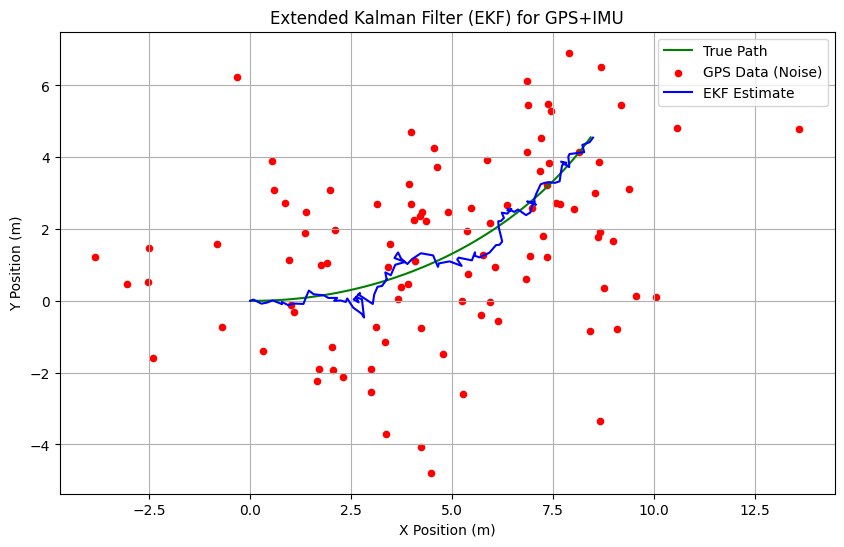

In [38]:
# Parameter EKF
dt = 0.1  # Waktu langkah
state = np.array([0, 0, 0])  # [x, y, theta] posisi awal
covariance = np.eye(3) * 0.1  # Covariance matrix awal
process_noise = np.diag([0.01, 0.01, 0.001])  # Proses noise (Q)
measurement_noise = np.diag([5, 5])  # Noise GPS (R)

# Model Gerak
def motion_model(state, control, dt):
    x, y, theta = state # Posisi saat ini
    v, omega = control # Kontrol IMU
    x_new = x + v * np.cos(theta) * dt # Gerakan non-linear
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + omega * dt # Rotasi
    return np.array([x_new, y_new, theta_new]) # Hasil pemodelan gerak

# Jacobian untuk model gerak
def jacobian_motion(state, control, dt):
    _, _, theta = state # Keadaan saat ini
    v, _ = control # Kecepatan dari IMU
    F = np.array([
        [1, 0, -v * np.sin(theta) * dt],
        [0, 1,  v * np.cos(theta) * dt],
        [0, 0,  1]
    ]) # Pembangunan Jacobian
    return F

# Model Pengamatan (GPS)
def measurement_model(state):
    return state[:2] # Mengambil posisi x dan y

# Jacobian untuk pengamatan
def jacobian_measurement():
    return np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

# Data GPS dan IMU Simulasi
np.random.seed(29) # Pembuatan data pseudorandom
true_positions = [np.array([0, 0, 0])] # Posisi sebenarnya
gps_data = [] # Data GPS
imu_controls = [] # Data IMU

#Mengisi nilai-nilai posisi dan sensor
for t in range(100):
    # Kontrol IMU (kecepatan linear dan sudut)
    v = 1.0 # Kecepatan linear
    omega = 0.1 # Kecepatan sudut
    imu_controls.append([v, omega]) # Simpan data IMU

    # Posisi sebenarnya
    true_position = motion_model(true_positions[-1], [v, omega], dt)
    true_positions.append(true_position) # Simpan posisi sebenarnya

    # Data GPS dengan noise
    gps = measurement_model(true_position) + np.random.multivariate_normal([0, 0], measurement_noise) 
    gps_data.append(gps) # Simpan data GPS

# Implementasi EKF 
estimated_positions = [state]
for i in range(len(gps_data)):
    # Predict step
    control = imu_controls[i]
    state_pred = motion_model(estimated_positions[-1], control, dt) # Membuat model dari stat saat ini
    F = jacobian_motion(estimated_positions[-1], control, dt) # Jacobian untuk Prediksi
    covariance_pred = F @ covariance @ F.T + process_noise

    # Update step
    z = gps_data[i]
    H = jacobian_measurement() # Implementasi Jacobian untuk Pengamatan
    y = z - measurement_model(state_pred) # Error
    S = H @ covariance_pred @ H.T + measurement_noise # Covariance
    K = covariance_pred @ H.T @ np.linalg.inv(S) # Kalman Gain

    state_est = state_pred + K @ y # Koreksi
    covariance = (np.eye(3) - K @ H) @ covariance_pred # Update Covariance
    estimated_positions.append(state_est) # Simpan hasil

# Plot Hasil
true_positions = np.array(true_positions)
gps_data = np.array(gps_data)
estimated_positions = np.array(estimated_positions)

# Visulaisasi
plt.figure(figsize=(10, 6))
plt.plot(true_positions[:, 0], true_positions[:, 1], 'g-', label='True Path')
plt.scatter(gps_data[:, 0], gps_data[:, 1], c='r', s=20, label='GPS Data (Noise)')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], 'b-', label='EKF Estimate')
plt.legend()
plt.title("Extended Kalman Filter (EKF) for GPS+IMU")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()

Hasil Analisis Output: 

Garis biru (estimasi EKF) mendekati garis hijau (jalur sebenarnya). Ini menunjukkan bahwa EKF bekerja dengan baik dalam memperkirakan posisi robot meskipun ada noise pada data GPS. Dengan membandingkan titik-titik merah (data GPS) dan garis biru (estimasi EKF), kita dapat melihat bagaimana EKF mampu menghaluskan noise dari data GPS dan memberikan estimasi yang lebih stabil dan akurat. Jalur estimasi EKF juga konsisten dan tidak terlalu berfluktuasi menunjukkan bahwa filter ini stabil dan dapat diandalkan dalam kondisi noise yang diberikan.

Secara keseluruhan, output visualisasi ini menunjukkan bahwa EKF mampu memperbaiki estimasi posisi robot dengan baik, meskipun terdapat noise pada data GPS, dan memberikan hasil yang mendekati jalur sebenarnya.

# Unscented Kalman Filter (UKF) untuk Estimasi Navigasi Robot Menggunakan Data GPS dan IMU

Tujuan UKF: Mengestimasi posisi dan orientasi robot dalam sistem non-linear menggunakan sigma points untuk meningkatkan akurasi tanpa memerlukan Jacobian.

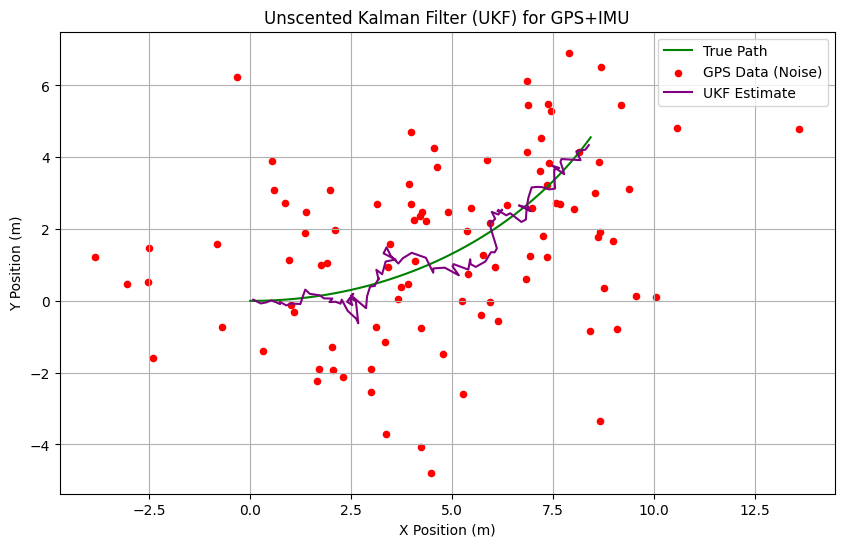

In [40]:
# UKF Setup
def fx(state, dt, control):
    x, y, theta = state # Posisi saat ini
    v, omega = control #  Data kontrol IMU
    x_new = x + v * np.cos(theta) * dt # Gerakan non-linear
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + omega * dt # Rotasi
    return np.array([x_new, y_new, theta_new]) # Hasil pemodelan gerak

def hx(state):
    return state[:2]  # Observasi (x, y)

# Sigma points untuk UKF
points = MerweScaledSigmaPoints(n=3, alpha=0.1, beta=2., kappa=1) # Penghitungan sigma points
ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=hx, dt=0.1, points=points) # UKF
ukf.x = np.array([0., 0., 0.])  # State awal
ukf.P *= 0.1 # Covariance awal
ukf.Q = np.diag([0.01, 0.01, 0.01])  # Noise proses
ukf.R = np.diag([5, 5])  # Noise pengamatan GPS

# Simulasi Data
np.random.seed(29) # Pembuatan data pseudorandom
dt = 0.1 # Interval waktu
gps_data = [] # Data GPS
controls = [] # Data kontrol IMU
true_states = [np.array([0, 0, 0])] # Posisi sebenarnya

for t in range(100):
    # Kontrol gerakan (kecepatan dan rotasi)
    control = np.array([1.0, 0.1])
    controls.append(control)

    # Gerak robot sebenarnya
    true_state = fx(true_states[-1], dt, control)
    true_states.append(true_state)

    # Pengamatan GPS dengan noise
    gps = true_state[:2] + np.random.multivariate_normal([0, 0], np.diag([5, 5]))
    gps_data.append(gps)

# Jalankan UKF
ukf_positions = [] # Estimasi posisi UKF
for i, control in enumerate(controls): # Looping untuk setiap kontrol
    ukf.predict(control=control) # Prediksi
    ukf.update(gps_data[i]) # Update
    ukf_positions.append(ukf.x) 

# Plot hasil
true_states = np.array(true_states) # Data posisi sebenarnya
gps_data = np.array(gps_data) # Data GPS
ukf_positions = np.array(ukf_positions) # Kumpulan estimasi UKF

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 1], 'g-', label='True Path')  # Jalur sebenarnya
plt.scatter(gps_data[:, 0], gps_data[:, 1], c='r', s=20, label='GPS Data (Noise)')  # Data GPS
plt.plot(ukf_positions[:, 0], ukf_positions[:, 1], '-', color='purple', label='UKF Estimate')  # Estimasi UKF
plt.legend()
plt.title("Unscented Kalman Filter (UKF) for GPS+IMU")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()

Hasil Analisis Output: 

Jalur sebenarnya ditampilkan sebagai garis hijau, data GPS yang berisik ditampilkan sebagai titik merah, dan estimasi UKF ditampilkan sebagai garis ungu. Dari plot tersebut, dapat dilihat bahwa data GPS memiliki banyak noise, yang menyebabkan penyebaran titik-titik merah. Namun, estimasi UKF berhasil mengikuti jalur sebenarnya dengan lebih baik, menunjukkan bahwa UKF efektif dalam mengurangi noise dan memberikan estimasi posisi yang lebih akurat

Hasil ini menunjukkan bahwa meskipun data GPS memiliki banyak noise, estimasi UKF berhasil mengikuti jalur sebenarnya dari robot dengan lebih akurat, membuktikan efektivitas UKF dalam mengurangi noise dan meningkatkan akurasi estimasi posisi.

# Tracking Objek Bergerak dengan Kalman Filter

Tujuan: Objek bergerak dengan pola sinusoidal, sensor mengukur posisi objek dengan noise, dan Kalman Filter digunakan untuk memperkirakan posisi sebenarnya dari objek.

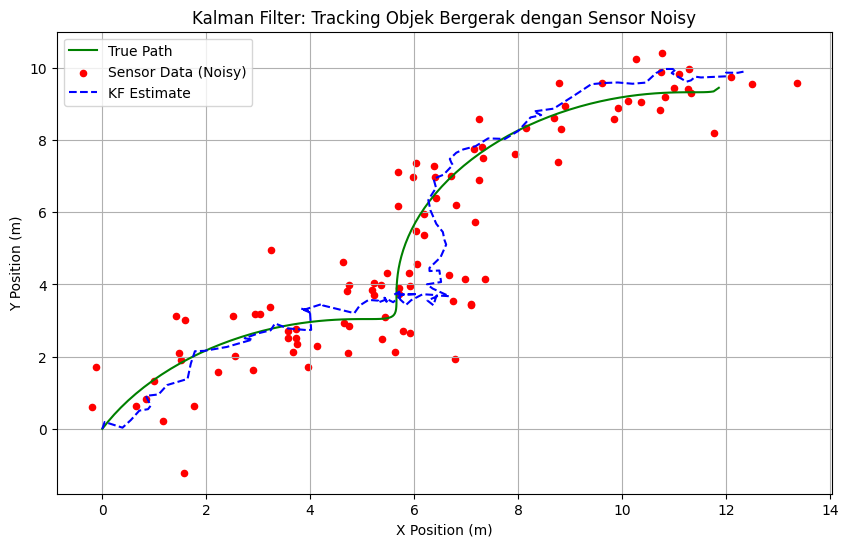

In [30]:
# Fungsi Model Gerak (Linear)
def motion_model(state, dt):
    # State: [posisi_x, kecepatan_x, posisi_y, kecepatan_y]
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ]) # Matriks Transisi
    return F @ state # Hasil pemodelan gerak

# Model Pengamatan (Hanya Posisi)
def measurement_model(state):
    return np.array([state[0], state[2]])  # [posisi_x, posisi_y]

# Jacobian untuk Pengamatan
def jacobian_measurement():
    return np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ]) # Hanya posisi x dan y

# Inisialisasi Variabel
dt = 0.1  # Timestep
state = np.array([0, 1, 0, 1])  # [pos_x, vel_x, pos_y, vel_y]
covariance = np.eye(4) * 0.1  # Covariance Matrix
process_noise = np.eye(4) * 0.01  # Proses noise (Q)
measurement_noise = np.eye(2) * 0.5  # Noise sensor posisi (R)

# Simulasi Data
np.random.seed(29) # Pembuatan data pseudorandom
true_states = [state] # Posisi sebenarnya
measurements = [] # Data pengamatan

for t in range(100):
    # Gerak objek sebenarnya (sinusoidal)
    state[0] += np.sin(0.1 * t) * 0.1  # Posisi X
    state[2] += np.cos(0.1 * t) * 0.1  # Posisi Y
    state = motion_model(state, dt) # Gerak objek
    true_states.append(state)

    # Sensor membaca posisi dengan noise
    measurement = measurement_model(state) + np.random.multivariate_normal([0, 0], measurement_noise)
    measurements.append(measurement)

# Jalankan Kalman Filter
estimated_states = [np.array([0, 1, 0, 1])] # Estimasi awal
for i in range(len(measurements)):
    # Predict step
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ])
    state_pred = F @ estimated_states[-1] # Prediksi keadaan
    covariance_pred = F @ covariance @ F.T + process_noise # Prediksi Covariance

    # Update step
    z = measurements[i] # Data pengamatan
    H = jacobian_measurement() # Jacobian untuk pengamatan
    y = z - H @ state_pred # Error pengamatan
    S = H @ covariance_pred @ H.T + measurement_noise # Covariance
    K = covariance_pred @ H.T @ np.linalg.inv(S) # Kalman Gain

    state_est = state_pred + K @ y # Koreksi
    covariance = (np.eye(4) - K @ H) @ covariance_pred # Update Covariance
    estimated_states.append(state_est) # Simpan hasil

# Plot Hasil
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 2], 'g-', label='True Path')  # Jalur sebenarnya
plt.scatter(measurements[:, 0], measurements[:, 1], c='r', s=20, label='Sensor Data (Noisy)')  # Data Sensor
plt.plot(estimated_states[:, 0], estimated_states[:, 2], 'b--', label='KF Estimate')  # Estimasi KF
plt.legend()
plt.title("Kalman Filter: Tracking Objek Bergerak dengan Sensor Noisy")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()


Hasil Analisis Output:


Output dari kode ini menunjukkan hasil estimasi posisi dan kecepatan objek yang bergerak di bidang 2D menggunakan Kalman Filter. Grafik yang dihasilkan memperlihatkan perbandingan antara posisi sebenarnya (true states), sensor yang terkontaminasi noise (Sensor Data), dan estimasi posisi oleh Kalman Filter (KF Estimates). 

Hasilnya menunjukkan bahwa Kalman Filter mampu memperbaiki estimasi posisi objek dengan cukup baik meskipun terdapat noise pada sensor, sehingga estimasi posisi lebih mendekati posisi sebenarnya dibandingkan dengan hasil penginderaan mentah.

# Tracking Drone dengan Gerakan Parabola

Tujuan: Drone terbang dengan gerakan parabola di 2D.
Sensor hanya memberikan data posisi drone (x, y) dengan noise.
Kalman Filter digunakan untuk memperkirakan posisi dan kecepatan drone.

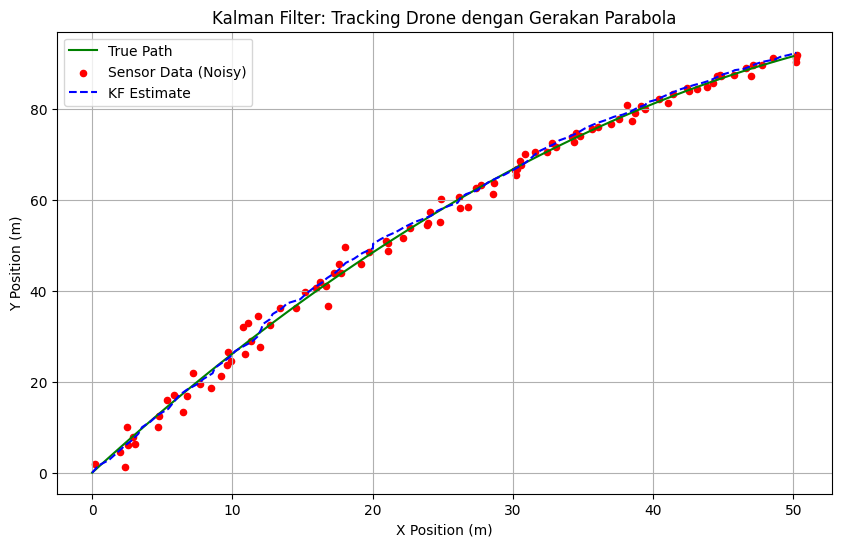

In [31]:
# Fungsi Model Gerak
def motion_model(state, dt):
    # State: [posisi_x, kecepatan_x, posisi_y, kecepatan_y]
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ]) # Matriks Transisi
    return F @ state # Hasil pemodelan gerak

# Model Pengamatan (Hanya Posisi)
def measurement_model(state):
    return np.array([state[0], state[2]])  # [posisi_x, posisi_y]

# Jacobian untuk Pengamatan
def jacobian_measurement():
    return np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ]) # Hanya posisi x dan y

# Inisialisasi Variabel
dt = 0.1  # Timestep
state = np.array([0, 5, 0, 15])  # [pos_x, vel_x, pos_y, vel_y]
covariance = np.eye(4) * 0.1  # Covariance Matrix
process_noise = np.eye(4) * 0.01  # Proses noise (Q)
measurement_noise = np.eye(2) * 0.5  # Noise sensor posisi (R)

# Simulasi Data
np.random.seed(29)
true_states = [state]
measurements = []

for t in range(100):
    # Gerakan parabola: Y dipengaruhi gravitasi
    state[3] -= 0.98 * dt  # Gravitasi (penurunan kecepatan Y)
    state = motion_model(state, dt)
    true_states.append(state)

    # Sensor membaca posisi dengan noise
    measurement = measurement_model(state) + np.random.multivariate_normal([0, 0], measurement_noise)
    measurements.append(measurement)

# Jalankan Kalman Filter
estimated_states = [np.array([0, 5, 0, 15])] # Estimasi awal
for i in range(len(measurements)): # Looping untuk setiap data pengamatan
    # Predict step
    F = np.array([
        [1, dt, 0,  0],
        [0,  1, 0,  0],
        [0,  0, 1, dt],
        [0,  0, 0,  1]
    ])
    state_pred = F @ estimated_states[-1] # Prediksi keadaan
    covariance_pred = F @ covariance @ F.T + process_noise # Prediksi Covariance

    # Update step
    z = measurements[i] # Data pengamatan
    H = jacobian_measurement() # Jacobian untuk pengamatan
    y = z - H @ state_pred # Error pengamatan
    S = H @ covariance_pred @ H.T + measurement_noise # Covariance
    K = covariance_pred @ H.T @ np.linalg.inv(S) # Kalman Gain

    state_est = state_pred + K @ y # Koreksi
    covariance = (np.eye(4) - K @ H) @ covariance_pred # Update Covariance
    estimated_states.append(state_est) # Simpan hasil

# Plot Hasil
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

plt.figure(figsize=(10, 6))
plt.plot(true_states[:, 0], true_states[:, 2], 'g-', label='True Path')  # Jalur sebenarnya
plt.scatter(measurements[:, 0], measurements[:, 1], c='r', s=20, label='Sensor Data (Noisy)')  # Data Sensor
plt.plot(estimated_states[:, 0], estimated_states[:, 2], 'b--', label='KF Estimate')  # Estimasi KF
plt.legend()
plt.title("Kalman Filter: Tracking Drone dengan Gerakan Parabola")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid()
plt.show()

Hasil Analisis Output:

Output dari kode ini menunjukkan hasil estimasi posisi dan kecepatan drone yang bergerak di bidang 2D menggunakan Kalman Filter. Grafik yang dihasilkan memperlihatkan perbandingan antara jalur sebenarnya dari drone (true path), hasil sensor yang terkontaminasi noise (noisy measurements), dan estimasi jalur oleh Kalman Filter (estimated path). Hasilnya menunjukkan bahwa Kalman Filter mampu memperbaiki estimasi posisi drone dengan cukup baik meskipun terdapat noise pada pengukuran, sehingga estimasi posisi lebih mendekati jalur sebenarnya dibandingkan dengan hasil penginderaan.